In [1]:
# gpu number setting
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"] = '1' ## gpu 번호 셋팅 윤건 :0, 기준 : 1, 준형 :2,

# Gpu growth setting
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)


# tensorflow & keras version check
print('tensorflow version : ' , tf.__version__)
print('keras version : ' , tf.keras.__version__)

# tensorflow gpu available check 
print('GPU available ? : ', tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None))

tensorflow version :  2.3.1
keras version :  2.4.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU available ? :  True


In [2]:
import pandas as pd
import numpy as np
import pickle
import tqdm
import random
import time

from sklearn.metrics import log_loss, roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from deepctr.models import *
from deepctr.feature_column import SparseFeat, DenseFeat, get_feature_names

In [3]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [14]:
data = pd.read_csv('../../Data/movie_201130_table_3_4_5_6.csv')

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [15]:
data['sa_id'] = data['sa_id'].apply(lambda x: str(x))
data['album_id'] = data['album_id'].apply(lambda x: str(x))

### label encoding

In [16]:
sparse_features = ['sa_id', 'album_id', 'pr_info']
dense_features = ['buy_tot', 'buy_history_price', 'i30_meta_price', 'movie_meta_price', 'release_date', 'run_time']
target = ['label']

In [17]:
lbe_dict = {}
for feat in sparse_features:
    print(feat)
    lbe = LabelEncoder()
    lbe.fit(data[feat])
    data[feat] = lbe.transform(data[feat])
    lbe_dict[feat] = lbe
    
mms = MinMaxScaler(feature_range=(0, 1))
data[dense_features] = mms.fit_transform(data[dense_features])

sa_id
album_id
pr_info


* save lbe_dict

In [19]:
with open('../../uplus_exp/model/all_feat/lbe_dict.pickle', 'wb') as f:
    pickle.dump(lbe_dict, f)

In [40]:
fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=data[feat].nunique(),embedding_dim=4)
                           for i,feat in enumerate(sparse_features)]

dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

feature_names = list(data.columns)
feature_names.remove('label')

In [41]:
train, test = train_test_split(data, test_size=0.2, random_state=2020)
train_model_input = {name:train[name] for name in feature_names}
test_model_input = {name:test[name] for name in feature_names}

In [42]:
len(train_model_input)

64

In [44]:
model = DeepFM(linear_feature_columns, dnn_feature_columns, task='binary')
# model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )
model.compile("adam", "binary_crossentropy", metrics=['AUC'], )

In [46]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [47]:
history = model.fit(train_model_input, train[target].values,
                    batch_size=2**19, epochs=100, verbose=1, validation_split=0.2,
                   callbacks=[callback]
                   )

Epoch 1/100


/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['buy_tot', '0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '6', '7', '8', '9', 'buy_history_price', 'i30_meta_price', 'movie_meta_price', 'release_date', 'run_time'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse Indexed

36/36 [==============================] - 7s 204ms/step - loss: 0.6649 - auc: 0.8587 - val_loss: 0.5868 - val_auc: 0.9061
Epoch 2/100
36/36 [==============================] - 6s 165ms/step - loss: 0.4352 - auc: 0.8970 - val_loss: 0.3371 - val_auc: 0.9341
Epoch 3/100
36/36 [==============================] - 5s 149ms/step - loss: 0.3257 - auc: 0.9358 - val_loss: 0.3209 - val_auc: 0.9371
Epoch 4/100
36/36 [==============================] - 5s 145ms/step - loss: 0.3120 - auc: 0.9403 - val_loss: 0.3213 - val_auc: 0.9364
Epoch 5/100
36/36 [==============================] - 5s 146ms/step - loss: 0.3020 - auc: 0.9439 - val_loss: 0.3206 - val_auc: 0.9371
Epoch 6/100
36/36 [==============================] - 5s 134ms/step - loss: 0.2939 - auc: 0.9466 - val_loss: 0.3182 - val_auc: 0.9391
Epoch 7/100
36/36 [==============================] - 5s 134ms/step - loss: 0.2859 - auc: 0.9495 - val_loss: 0.3139 - val_auc: 0.9419
Epoch 8/100
36/36 [==============================] - 5s 135ms/step - loss: 0.2771

In [48]:
pred_ans = model.predict(test_model_input, batch_size=2**16)
print("test LogLoss", round(log_loss(test[target].values, pred_ans), 4))
print("test AUC", round(roc_auc_score(test[target].values, pred_ans), 4))

test LogLoss 0.3121
test AUC 0.9411


In [49]:
from deepctr.layers import custom_objects

In [50]:
model.save('../../uplus_exp/model/all_feat/earlyStopped/')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../../uplus_exp/model/all_feat/earlyStopped/assets


In [36]:
from sklearn.metrics import classification_report, confusion_matrix

In [37]:
y_pred = pred_ans.round()

In [38]:
conf = confusion_matrix(test[target], y_pred)
print(conf)

[[890793 511418]
 [411158 991323]]


In [39]:
report = classification_report(test[target], y_pred, target_names=['0', '1'])
report_dict = classification_report(test[target], y_pred, target_names=['0', '1'], output_dict = True)
print(report)

              precision    recall  f1-score   support

           0       0.68      0.64      0.66   1402211
           1       0.66      0.71      0.68   1402481

    accuracy                           0.67   2804692
   macro avg       0.67      0.67      0.67   2804692
weighted avg       0.67      0.67      0.67   2804692



In [79]:
user_origin = int(lbe_dict['sa_id'].transform(['500150964610']))

In [82]:
user_col = ['sa_id', 'view_no', 'buy_tot']
cont_col = list(data.columns.difference(set(user_col)))

In [83]:
user_tab = data[user_col]
cont_tab = data[cont_col]

In [84]:
user_uni_tab = user_tab.loc[list(user_tab['sa_id'].drop_duplicates().index)]
cont_uni_tab = cont_tab.loc[list(cont_tab['album_id'].drop_duplicates().index)]

In [85]:
user_uni_tab[user_uni_tab['sa_id'] == user_origin]

,sa_id,view_no,buy_tot
4156478,859288,1,0.004785


In [86]:
test_tab = cont_uni_tab.copy()

In [87]:
for feat in user_col:
    test_tab[feat] = user_uni_tab[user_uni_tab['sa_id'] == 700773][feat].values[0]

In [88]:
f_test_model_input = {name:test_tab[name] for name in feature_names}

In [89]:
test_tab

,0,1,10,11,12,13,14,15,16,17,18,19,2,20,21,22,23,24,25,26,27,28,29,3,30,31,32,33,34,35,36,37,38,39,4,40,41,42,43,44,45,46,47,48,49,5,50,51,52,53,54,6,7,8,9,album_id,buy_history_price,i30_meta_price,label,movie_meta_price,pr_info,release_date,run_time,sa_id,view_no,buy_tot
0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,9174,0.054945,0.051020,1,0.051020,3,0.988236,0.281167,700773,0,0.0
30500,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,11779,0.283516,0.202041,0,0.202041,2,0.999764,0.305040,700773,0,0.0
31873,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,4715,0.030769,0.028571,0,0.028571,4,0.952768,0.251989,700773,0,0.0
33439,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,11453,0.000000,0.000000,1,0.000000,3,0.999290,0.286472,700773,0,0.0
88576,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3008,0.030769,0.028571,0,0.028571,4,0.940414,0.246684,700773,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28940999,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,187,0.000000,0.028571,0,0.028571,4,0.893786,0.358090,700773,0,0.0
28942737,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,7671,0.228571,0.365306,0,0.365306,2,0.976494,0.352785,700773,0,0.0
28944348,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2639,0.000000,0.028571,0,0.028571,2,0.763913,0.294430,700773,0,0.0
28945629,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,5100,0.000000,0.028571,0,0.028571,2,0.953127,0.257294,700773,0,0.0


In [90]:
test_pred = model.predict(f_test_model_input, batch_size=2**16)

In [91]:
test_pred.argsort()

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [92]:
np.reshape(test_pred, (-1))

array([1.0000000e+00, 1.5981450e-07, 1.3941394e-07, ..., 1.4417247e-07,
       1.2442830e-07, 1.5471122e-07], dtype=float32)

In [93]:
top10_idx = np.reshape(test_pred, (-1)).argsort()[-10:]

In [94]:
top10_idx

array([2524,  184,  732,  737, 1625,  745, 1553, 1527,  171,    0])

In [95]:
test_pred[56]

array([1.5498514e-07], dtype=float32)

In [96]:
top10_album_idx = test_tab.iloc[top10_idx]['album_id'].values

In [97]:
top10_album_idx

array([ 5152,  1579, 11741,  9135,  2386,   670,   876,  8890,  4795,
        9174])

In [98]:
album_list = lbe_dict['album_id'].inverse_transform(top10_album_idx)

In [103]:
tmp = pd.read_csv('../../Data/movie_201118.csv')

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,26,27,28,29,37,39) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [105]:
title = []

for album in album_list:
    title.append(tmp[tmp['album_id'] == album]['album_name'].values[0])

In [106]:
title

['[우리말]닥터 스트레인지',
 '미션 임파서블 3',
 '[우리말] 말레피센트 2(캐치온)',
 '82년생 김지영',
 '투모로우',
 '와일드 카드(2003)',
 '제로 다크 서티',
 '007 스펙터(캐치온)',
 '코드네임: 콜드워',
 '신의 한 수: 귀수편']

In [40]:
import matplotlib.pyplot as plt

(array([216525., 158847., 195279., 260923., 317850., 335381., 352320.,
        371191., 339589., 256787.]),
 array([0.00462385, 0.09534254, 0.18606122, 0.27677992, 0.36749858,
        0.45821726, 0.54893595, 0.63965464, 0.7303733 , 0.821092  ,
        0.9118107 ], dtype=float32),
 <a list of 10 Patch objects>)

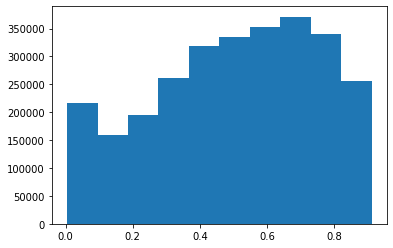

In [41]:
plt.hist(pred_ans)

In [16]:
model.save(filepath='./model/201120/')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./model/201120/assets


In [107]:
data

,sa_id,album_id,label,view_no,buy_tot,buy_history_price,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,i30_meta_price,movie_meta_price,pr_info,release_date,run_time
0,0,9174,1,0,0.000000,0.054945,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.051020,0.051020,3,0.988236,0.281167
1,22,9174,1,1,0.014354,0.054945,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.051020,0.051020,3,0.988236,0.281167
2,57,9174,1,1,0.004785,0.054945,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.051020,0.051020,3,0.988236,0.281167
3,68,9174,1,1,0.038278,0.054945,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.051020,0.051020,3,0.988236,0.281167
4,319,9174,1,1,0.004785,0.054945,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.051020,0.051020,3,0.988236,0.281167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28948275,1046745,10065,0,0,0.000000,0.164835,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.202041,0.202041,3,0.998944,0.315650
28948276,1511615,10065,0,1,0.004785,0.164835,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.202041,0.202041,3,0.998944,0.315650
28948277,18478,10065,0,0,0.000000,0.164835,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.202041,0.202041,3,0.998944,0.315650
28948278,931340,10065,0,0,0.000000,0.164835,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.202041,0.202041,3,0.998944,0.315650


In [111]:
user_uni_tab

,sa_id,view_no,buy_tot
0,0,0,0.000000
1,22,1,0.014354
2,57,1,0.004785
3,68,1,0.038278
4,319,1,0.004785
...,...,...,...
28785995,1401528,0,0.000000
28845606,786980,0,0.000000
28848954,1381118,0,0.000000
28858660,136643,0,0.000000


In [112]:
cont_uni_tab

,0,1,10,11,12,13,14,15,16,17,18,19,2,20,21,22,23,24,25,26,27,28,29,3,30,31,32,33,34,35,36,37,38,39,4,40,41,42,43,44,45,46,47,48,49,5,50,51,52,53,54,6,7,8,9,album_id,buy_history_price,i30_meta_price,label,movie_meta_price,pr_info,release_date,run_time
0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,9174,0.054945,0.051020,1,0.051020,3,0.988236,0.281167
30500,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,11779,0.283516,0.202041,0,0.202041,2,0.999764,0.305040
31873,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,4715,0.030769,0.028571,0,0.028571,4,0.952768,0.251989
33439,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,11453,0.000000,0.000000,1,0.000000,3,0.999290,0.286472
88576,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3008,0.030769,0.028571,0,0.028571,4,0.940414,0.246684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28940999,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,187,0.000000,0.028571,0,0.028571,4,0.893786,0.358090
28942737,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,7671,0.228571,0.365306,0,0.365306,2,0.976494,0.352785
28944348,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2639,0.000000,0.028571,0,0.028571,2,0.763913,0.294430
28945629,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,5100,0.000000,0.028571,0,0.028571,2,0.953127,0.257294
